In [4]:
import pandas as pd

path = '../../preprocessed_data&EDA/dataset/internet_service_churn.csv'
df_re = pd.read_csv(path, encoding='utf-8')
df_re.head(1)

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0


In [5]:
df_re.shape

(72274, 11)

In [6]:
df_re.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


# ☀ preprocessing - ml

In [7]:
# id 컬럼 삭제
df_re = df_re.drop(columns=['id'])

In [8]:
# 음수값 제거
df_re = df_re[df_re['subscription_age'] >= 0]

In [9]:
# `reamining_contract` grouping
import numpy as np

conditions = [
    df_re['reamining_contract'].isnull(),
    df_re['reamining_contract'] == 0,
    df_re['reamining_contract'] > 0
]

choices = ['no_contract', 'expired', 'active']

df_re['contract_type'] = np.select(conditions, choices, default='unknown')

In [10]:
# 원핫인코딩
df_re = pd.get_dummies(df_re, columns=['contract_type'], dtype=int)

In [11]:
# `reamining_contract` drop
df_re = df_re.drop(columns=['reamining_contract'])

In [12]:
df_re.head(2)

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn,contract_type_active,contract_type_expired,contract_type_no_contract
0,1,0,11.95,25,0,8.4,2.3,0,0,1,0,0
1,0,0,8.22,0,0,0.0,0.0,0,1,0,0,1


In [13]:
# `download_avg` NaN 드랍
df_re = df_re.dropna(subset=['download_avg'])

In [14]:
# `download_avg`의 널값을 제거하면, `upload_avg`의 널값도 제거된 것을 확인
df_re['upload_avg'].isna().sum()

0

In [15]:
# 구독 상태 통합 컬럼 생성
df_re['subscription_label'] = df_re.apply(
    lambda row: (
        'both' if row['is_tv_subscriber'] == 1 and row['is_movie_package_subscriber'] == 1 else
        'tv' if row['is_tv_subscriber'] == 1 else
        'movie' if row['is_movie_package_subscriber'] == 1 else
        'none'
    ),
    axis=1
)

df_re.drop(['is_tv_subscriber', 'is_movie_package_subscriber'], axis=1, inplace=True)

# 원핫인코딩
df_re = pd.get_dummies(df_re, columns=['subscription_label'], prefix='sub')

dummy_cols = [col for col in df_re.columns if col.startswith('sub_')]
df_re[dummy_cols] = df_re[dummy_cols].astype(int)

In [16]:
import numpy as np

df_re_log = df_re.copy()

for col in ['bill_avg', 'download_avg', 'upload_avg']:
    df_re_log[f'{col}_log'] = np.log1p(df_re_log[col])  # log(1+x)으로 0 방지

In [17]:
# 기존 컬럼 삭제
df_re_log.drop(['bill_avg', 'download_avg', 'upload_avg'], axis=1, inplace=True)

In [18]:
df_re_log.columns

Index(['subscription_age', 'service_failure_count', 'download_over_limit',
       'churn', 'contract_type_active', 'contract_type_expired',
       'contract_type_no_contract', 'sub_both', 'sub_movie', 'sub_none',
       'sub_tv', 'bill_avg_log', 'download_avg_log', 'upload_avg_log'],
      dtype='object')

In [19]:
# df_re_log.to_csv("re_log_model_preprocessed.csv", index=False, encoding='utf-8-sig')

# from google.colab import files
# files.download("re_log_model_preprocessed.csv")

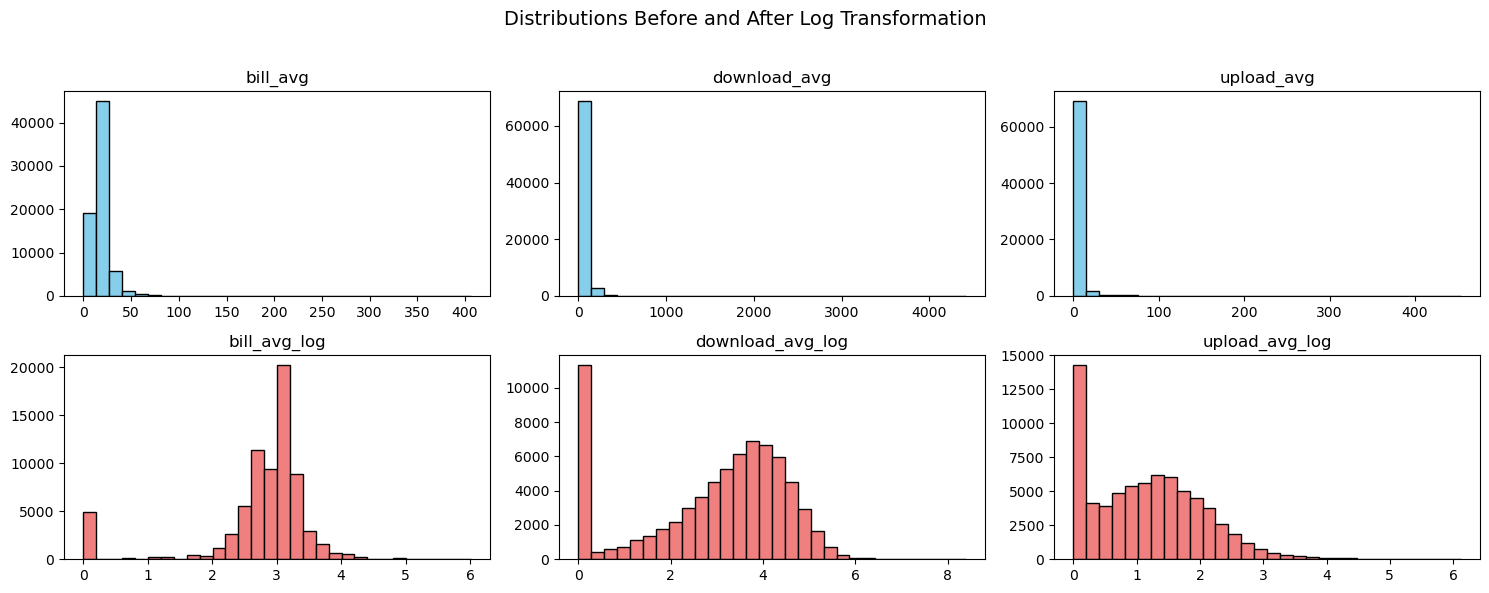

In [20]:
import matplotlib.pyplot as plt

cols = ['bill_avg', 'download_avg', 'upload_avg']
log_cols = ['bill_avg_log', 'download_avg_log', 'upload_avg_log']

fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i in range(len(cols)):
    # 원본 분포
    axes[0, i].hist(df_re[cols[i]], bins=30, color='skyblue', edgecolor='black')
    axes[0, i].set_title(cols[i])

    # 로그 변환 분포
    axes[1, i].hist(df_re_log[log_cols[i]], bins=30, color='lightcoral', edgecolor='black')
    axes[1, i].set_title(log_cols[i])

plt.suptitle('Distributions Before and After Log Transformation', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [21]:
df_re.shape

(71892, 14)

In [22]:
df_re_log.shape

(71892, 14)